In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from utils.engine import evaluate

## Configure Path

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

num_classes = 2
CLASSES = ["BG","AR","non-AR"]

DATABASE_BASE = "/home/mirap/0_DATABASE/1_sperm_acrosome_reaction/1_AR_400/"
test_image_path = DATABASE_BASE + "5_folds/fold_5/190305_D253_MO_400X_(46).JPG"

model_save_path = "trained_model/1_AR_400/v1/"
model_save_name = model_save_path + "faster_rcnn_resnet50_fpn_set1"

In [3]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define model

In [4]:
import torchvision.models.detection as torch_det

detection_model = torch_det.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

/home/mirap/.conda/envs/tf2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mirap/.conda/envs/tf2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = torch_det.faster_rcnn.FastRCNNPredictor(in_features, num_classes+1)

## Load Model

In [6]:
detection_model.load_state_dict(torch.load(model_save_name+".pth"))
detection_model.to(DEVICE)
detection_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## Load image

In [20]:
# load the image from disk
image = cv2.imread(test_image_path)
orig = image.copy()

# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))

# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)

In [21]:
# send the input to the device and pass the it through the network to
# get the detections and predictions
image = image.to(DEVICE)
detections = detection_model(image)[0]

## Display result

In [27]:
# Set iou_threshold (minimum confidence)
iou_threshold = 0.5

COLORS = [(255, 0, 0), (255, 255, 0), (0, 255, 255)]
# loop over the detections
for i in range(0, len(detections["boxes"])):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections["scores"][i]
    # filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > iou_threshold :
        # extract the index of the class label from the detections,
        # then compute the (x, y)-coordinates of the bounding box for the object
        idx = int(detections["labels"][i])
        box = detections["boxes"][i].detach().cpu().numpy()
        (startX, startY, endX, endY) = box.astype("int")
        
        # display the prediction to our terminal
        label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
        print("[INFO] {}".format(label))
        
        # draw the bounding box and label on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY),COLORS[idx], 2)
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(orig, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

[INFO] AR: 98.80%
[INFO] AR: 98.73%
[INFO] AR: 98.69%
[INFO] AR: 98.66%
[INFO] AR: 98.56%
[INFO] AR: 98.26%
[INFO] AR: 98.01%
[INFO] AR: 98.00%
[INFO] AR: 97.43%
[INFO] AR: 95.25%
[INFO] non-AR: 90.14%
[INFO] AR: 87.49%
[INFO] AR: 84.87%
[INFO] AR: 83.93%
[INFO] AR: 67.79%
[INFO] non-AR: 56.63%
[INFO] non-AR: 53.39%
[INFO] AR: 51.73%
[INFO] AR: 50.74%
[INFO] AR: 50.25%


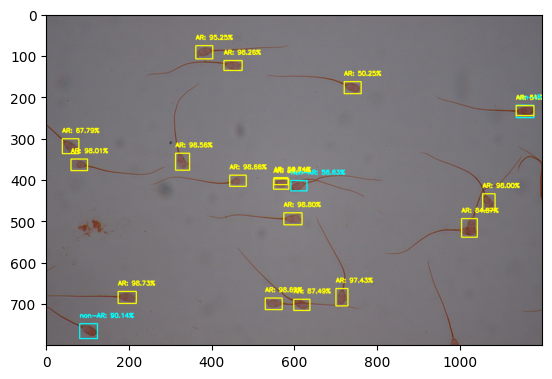

In [28]:
# show the output image
plt.imshow(orig)